# Xây dựng mô hình học máy và so sánh hiệu quả giữa chúng

## Import thư viện cần dùng

In [ ]:
# System library
import os
import time
import pickle
import warnings

# Statistics library
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import (
    KFold,
    cross_validate
)
# Preprocessing
from sklearn.preprocessing import LabelEncoder

In [ ]:
SEED = 42
RANDOM_STATE=123
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(rc = {'figure.figsize':(15, 10)})
np.random.seed(SEED)

DATA_PATH = 'data/'
MODEL_PATH = 'model/'

## Phần II: Xây dựng mô hình

### Load Data from source

In [ ]:
# Load processed data
X_train_cleaner_and_reduction_ = np.load(os.path.join(MODEL_PATH, 'X_train_cleaner_and_reduction_.npy'))
X_test_cleaner_and_reduction_ = np.load(os.path.join(MODEL_PATH, 'X_test_cleaner_and_reduction_.npy'))
y_train = np.load(os.path.join(MODEL_PATH, 'y_train.npy'))
y_test = np.load(os.path.join(MODEL_PATH, 'y_test.npy'))



In [ ]:
le = pickle.load(open(os.path.join(MODEL_PATH, 'le_.pkl'), 'rb'))
le.classes_

array(['An sinh', 'Bất động sản', 'Giáo dục', 'Giải trí', 'Kinh doanh',
       'Pháp luật', 'Sức khỏe', 'Sức mạnh số', 'Thế giới', 'Thể thao',
       'Việc làm', 'Văn hóa', 'Xe ++', 'Xã hội'], dtype=object)

Chúng ta sẽ sử dụng tối ưu tham số để tìm ra mô hình tốt nhất và sau đó sẽ so sánh chúng với nhau

In [ ]:
def evaluation_model(y_pred, y_test):
  acc = accuracy_score(y_test, y_pred)
  print("- Acc = {}".format(acc))
  print(classification_report(y_test, y_pred, target_names=le.classes_))
  return acc

def train_model(estimator, X_train, y_train, X_test, y_test):
  estimator_start = time.time()
  estimator.fit(X_train, y_train)
  print("Fit data completely ...")
  estimator_train_time = int(time.time() - estimator_start)
  y_pred = estimator.predict(X_test)

  estimator_acc = evaluation_model(y_pred, y_test)
  return estimator, estimator_acc, estimator_train_time

def create_params_based_on_estimator(estimator, X_train, y_train, scoring='accuracy', return_train_score=True, cv=None):
  params = dict (
      estimator=estimator,
      X=X_train,
      y=y_train,
      scoring=scoring,
      return_train_score=return_train_score,
      cv=cv,
      n_jobs=-1,
      verbose=3
  )
  return params

def get_loss_in_each_category(confustion_matrix):
  num_of_true_categories = np.diag(confustion_matrix)
  categories, cnt = np.unique(y_test, return_counts=True)
  categories = le.inverse_transform(categories)
  return pd.DataFrame({
      'categories': categories,
      'num_of_true_categories': num_of_true_categories,
      'num_of_false_categories': np.round(((cnt - num_of_true_categories) / cnt), 2),
      'total': cnt
  })

In [ ]:
skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### 2.2 Ensemble Methods

Theo như lý thuyết, việc xây dựng các mô hình Ensemble thường cho hiệu suất tốt hơn so với Single Classifier, vì vậy ở phần này, chúng ta sẽ dùng các công cụ Boosting, Bagging trường hợp đặc biệt có Random Forest và XGBoost

#### Random Forest

In [ ]:

cv_params_rf = create_params_based_on_estimator(RandomForestClassifier(n_estimators=500, max_depth=20, n_jobs=-1, random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_,
                                                 y_train,
                                                 cv=skf)

rf_cv = cross_validate(
    **cv_params_rf
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.6min finished


In [ ]:
rf_clf, rf_acc, rf_time = train_model(cv_params_rf['estimator'], X_train_cleaner_and_reduction_,
                                         y_train, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8740875912408759
              precision    recall  f1-score   support

     An sinh       0.83      0.58      0.68       175
Bất động sản       0.89      0.92      0.90       361
    Giáo dục       0.90      0.96      0.93       416
    Giải trí       0.90      0.74      0.81       174
  Kinh doanh       0.79      0.86      0.83       312
   Pháp luật       0.91      0.86      0.88       120
    Sức khỏe       0.94      0.97      0.95       374
 Sức mạnh số       0.93      0.80      0.86       227
    Thế giới       0.89      0.80      0.84       207
    Thể thao       0.96      0.98      0.97       418
    Việc làm       0.75      0.78      0.76       213
     Văn hóa       0.82      0.89      0.85       307
       Xe ++       0.91      0.95      0.93       266
      Xã hội       0.75      0.77      0.76       266

    accuracy                           0.87      3836
   macro avg       0.87      0.85      0.86      3836
weighted avg       0.88      

[[102   2   6   0   1   0   5   2   2   2  30   2   3  18]
 [  0 332   1   0  12   0   2   1   1   0   2   1   2   7]
 [  0   2 401   3   1   0   0   0   0   0   2   6   0   1]
 [  1   1   4 129   3   0   2   1   0   2   0  30   0   1]
 [  1  12   1   0 269   1   2   2   6   0   8   2   4   4]
 [  0   4   0   0   4 103   0   0   1   0   1   0   0   7]
 [  1   0   4   0   5   0 361   2   0   0   0   1   0   0]
 [  0   2   5   0  17   2   2 182   2   4   0   4   2   5]
 [  1   0   8   0   9   4   4   1 166   0   4   4   2   4]
 [  0   0   0   4   0   1   0   0   0 410   0   3   0   0]
 [ 11   2   4   0  10   0   1   1   2   0 166   4   3   9]
 [  3   1   4   7   3   0   2   1   2   3   1 274   0   6]
 [  0   0   2   0   2   0   0   1   0   2   0   0 252   7]
 [  3  15   7   0   4   2   3   1   4   2   7   3   9 206]]


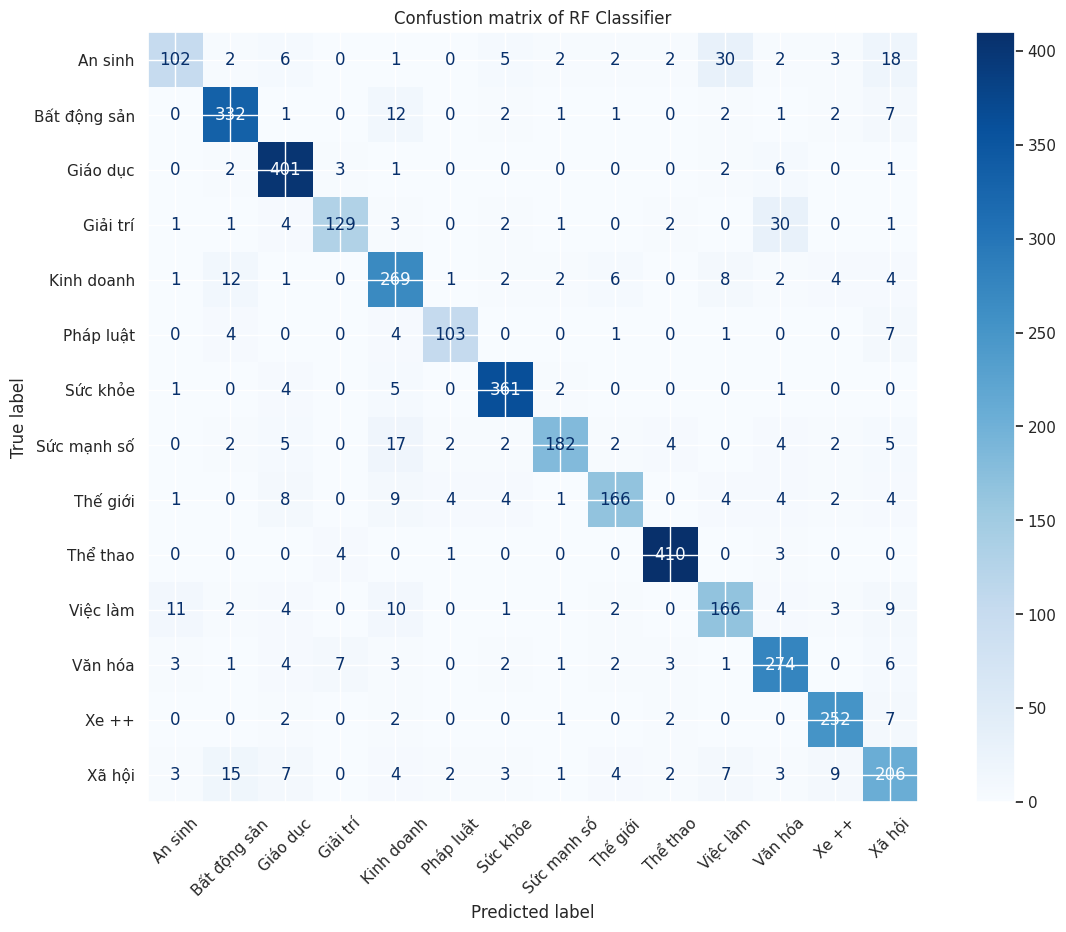

In [ ]:
rf_disp = ConfusionMatrixDisplay.from_estimator(
      rf_clf,
      X_test_cleaner_and_reduction_,
      y_test,
      display_labels=le.classes_,
      cmap=plt.cm.Blues,
)
rf_disp.ax_.set_title("Confustion matrix of RF Classifier")
rf_disp.ax_.tick_params(axis='x', rotation=45)

print(rf_disp.confusion_matrix)

In [ ]:
get_loss_in_each_category(rf_disp.confusion_matrix)

,categories,num_of_true_categories,num_of_false_categories,total
0,An sinh,102,0.42,175
1,Bất động sản,332,0.08,361
2,Giáo dục,401,0.04,416
3,Giải trí,129,0.26,174
4,Kinh doanh,269,0.14,312
5,Pháp luật,103,0.14,120
6,Sức khỏe,361,0.03,374
7,Sức mạnh số,182,0.20,227
8,Thế giới,166,0.20,207
9,Thể thao,410,0.02,418


In [ ]:
with open(os.path.join(MODEL_PATH, 'rf_clf.pkl'), 'wb') as f:
  pickle.dump(rf_clf, f)

with open(os.path.join(MODEL_PATH, 'rf_cv.pkl'), 'wb') as f:
  pickle.dump(rf_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'rf_clf.pkl'), 'rb') as f:
  rf_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'rf_cv.pkl'), 'rb') as f:
  rf_cv = pickle.load(f)

In [ ]:
rf_cv

{'fit_time': array([277.13602948, 277.91846108, 271.82812595, 271.77588105,
        136.82453799]),
 'score_time': array([1.11488175, 1.04678774, 0.72728181, 0.64651084, 0.30659127]),
 'test_score': array([0.85810056, 0.86368715, 0.87206704, 0.87653631, 0.86752376]),
 'train_score': array([1., 1., 1., 1., 1.])}

#### Boosting

Ở phần này, chúng tôi sẽ sử dụng XGBoost vì 2 lí do chính sau:
* XGBoost là một thư viện mã nguồn mở được ứng dụng rộng rãi trong lĩnh vực Machine Learning vì hiệu suất tuyệt vời của nó
* Có sự hỗ trợ của GPU nhằm giảm thiểu thời gian đào tạo mô hình

Để đánh giá được độ hiệu quả, chúng ta sẽ đánh giá thông qua Gradient Boosting, XGBoost và AdaBoosting cho mô hình Gaussian Naive Bayes

##### Boosting Gaussian Navie Bayes

In [ ]:
gnb_params = dict(
    estimator=GaussianNB(),
    n_estimators=100,
    learning_rate=0.01,
    random_state=RANDOM_STATE,
)

cv_params_gnb_boosting = create_params_based_on_estimator(AdaBoostClassifier(**gnb_params),
                                                 X_train_cleaner_and_reduction_,
                                                 y_train,
                                                 cv=skf)

gnb_boosting_cv = cross_validate(
    **cv_params_gnb_boosting
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.2min finished


In [ ]:
gnb_boosting_clf, gnb_boosting_acc, gnb_boosting_time = train_model(cv_params_gnb_boosting['estimator'], X_train_cleaner_and_reduction_,
                                         y_train, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8592283628779979
              precision    recall  f1-score   support

     An sinh       0.73      0.65      0.69       175
Bất động sản       0.88      0.88      0.88       361
    Giáo dục       0.89      0.92      0.90       416
    Giải trí       0.79      0.80      0.80       174
  Kinh doanh       0.81      0.83      0.82       312
   Pháp luật       0.81      0.91      0.85       120
    Sức khỏe       0.86      0.96      0.91       374
 Sức mạnh số       0.91      0.80      0.85       227
    Thế giới       0.87      0.80      0.83       207
    Thể thao       0.97      0.97      0.97       418
    Việc làm       0.72      0.83      0.77       213
     Văn hóa       0.89      0.81      0.85       307
       Xe ++       0.91      0.96      0.93       266
      Xã hội       0.78      0.70      0.74       266

    accuracy                           0.86      3836
   macro avg       0.85      0.84      0.84      3836
weighted avg       0.86      

[[114   3   3   0   1   2   6   0   1   0  30   2   1  12]
 [  1 316   2   0  13   1   6   1   2   0   4   0   1  14]
 [  5   0 381   0   3   0   4   2   2   1  14   3   0   1]
 [  1   2   2 140   6   0   3   2   0   2   0  16   0   0]
 [  3  19   3   1 258   2   5   3   3   0   6   1   5   3]
 [  1   1   0   0   0 109   1   1   2   0   0   0   3   2]
 [  2   1   2   0   5   0 358   2   0   0   3   0   0   1]
 [  0   1  11   0   8   2   6 182   6   3   1   1   3   3]
 [  4   1   8   1   6   8   5   1 165   0   2   2   1   3]
 [  0   0   1   5   0   3   0   0   1 407   0   1   0   0]
 [ 14   0   2   4   6   0   1   2   0   0 177   1   0   6]
 [  1   1   7  26   2   1  11   2   1   3   1 248   1   2]
 [  0   0   1   0   3   0   0   2   1   0   0   0 255   4]
 [ 10  14   4   0   8   7  10   0   5   2   7   3  10 186]]


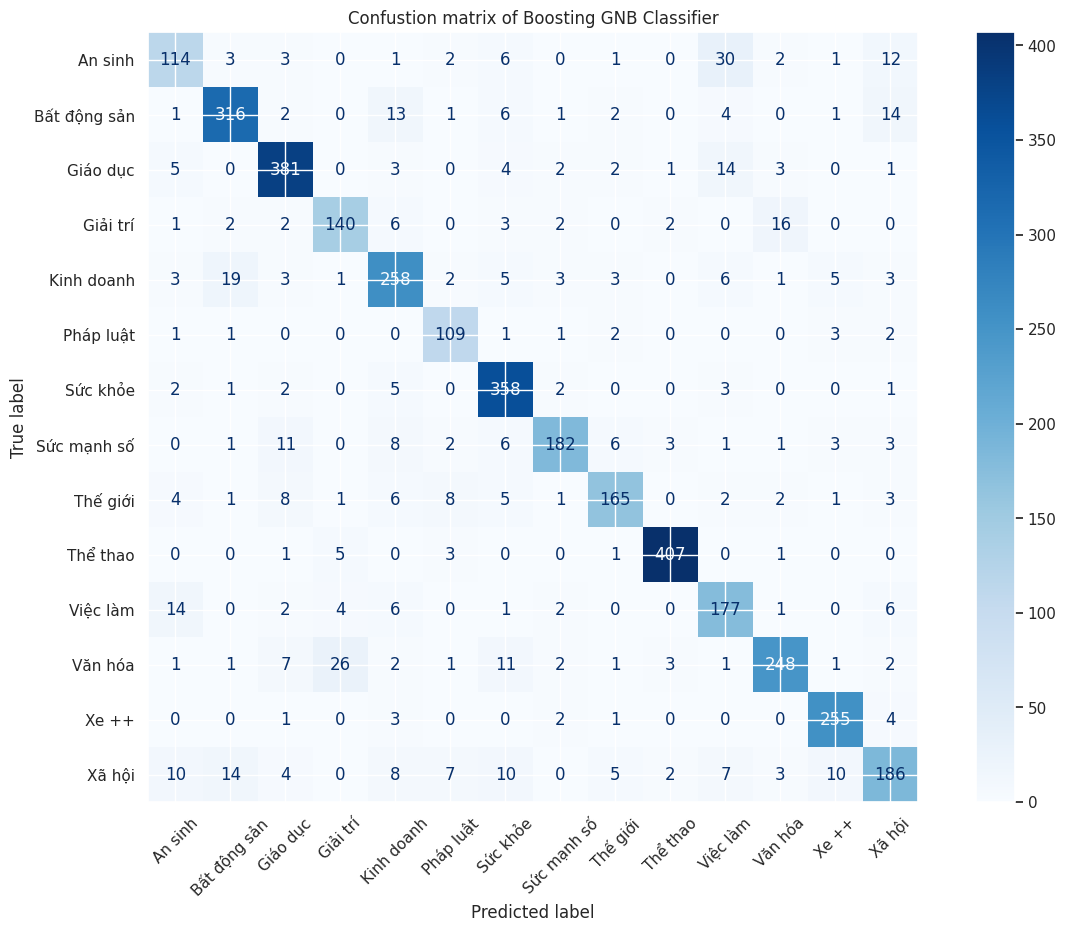

In [ ]:
boosting_gnb_disp = ConfusionMatrixDisplay.from_estimator(
      gnb_boosting_clf,
      X_test_cleaner_and_reduction_,
      y_test,
      display_labels=le.classes_,
      cmap=plt.cm.Blues,
)
boosting_gnb_disp.ax_.set_title("Confustion matrix of Boosting GNB Classifier")
boosting_gnb_disp.ax_.tick_params(axis='x', rotation=45)

print(boosting_gnb_disp.confusion_matrix)

In [ ]:
get_loss_in_each_category(boosting_gnb_disp.confusion_matrix)


,categories,num_of_true_categories,num_of_false_categories,total
0,An sinh,114,0.35,175
1,Bất động sản,316,0.12,361
2,Giáo dục,381,0.08,416
3,Giải trí,140,0.20,174
4,Kinh doanh,258,0.17,312
5,Pháp luật,109,0.09,120
6,Sức khỏe,358,0.04,374
7,Sức mạnh số,182,0.20,227
8,Thế giới,165,0.20,207
9,Thể thao,407,0.03,418


In [ ]:
with open(os.path.join(MODEL_PATH, 'gnb_boosting_clf.pkl'), 'wb') as f:
  pickle.dump(gnb_boosting_clf, f)

with open(os.path.join(MODEL_PATH, 'gnb_boosting_cv.pkl'), 'wb') as f:
  pickle.dump(gnb_boosting_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'gnb_boosting_clf.pkl'), 'rb') as f:
  gnb_boosting_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'gnb_boosting_cv.pkl'), 'rb') as f:
  gnb_boosting_cv = pickle.load(f)

In [ ]:
gnb_boosting_cv

{'fit_time': array([205.97001481, 206.25052929, 168.23785639, 168.94960523,
        100.89068127]),
 'score_time': array([38.05672312, 37.81662941, 42.60062957, 40.87125254, 21.9335103 ]),
 'test_score': array([0.82625698, 0.85642458, 0.84301676, 0.84581006, 0.84237004]),
 'train_score': array([0.95558039, 0.94719933, 0.95390418, 0.95236765, 0.95097765])}